# Adding to the API Documentation

Documentation is an integral part of every collaborative software project. Good documentation not only encourages users of the package to try out different functionalities, but it also makes maintaining and expanding code significantly easier. If you want to improve ProbNum's documentation or learn how to write documentation for your newly implemented functionality, keep reading.

## Docstrings

The main form of documentation are `docstrings`, multi-line comments beneath a class or function definition with a specific syntax, which detail its functionality. This package uses the
[NumPy docstring format](https://numpydoc.readthedocs.io/en/latest/format.html#numpydoc-docstring-guide>). As a rule, all functions which are exposed to the user *must* have appropriate docstrings. Below is an example of a docstring for a probabilistic numerical method.


In [ ]:
# %load -s problinsolve ../../../src/probnum/linalg/linearsolvers/linearsolvers.py
def problinsolve(
    A: SquareLinOp,
    b: RandomVecMat,
    A0: Optional["SquareLinOp"] = None,
    Ainv0: Optional["SquareLinOp"] = None,
    x0: Optional[RandomVecMat] = None,
    assume_A: str = "sympos",
    maxiter: Optional[int] = None,
    atol: float = 10 ** -6,
    rtol: float = 10 ** -6,
    callback: Optional[Callable] = None,
    **kwargs
) -> Tuple[
    "probnum.RandomVariable", "probnum.RandomVariable", "probnum.RandomVariable", Dict
]:
    """
    Infer a solution to the linear system :math:`A x = b` in a Bayesian framework.

    Probabilistic linear solvers infer solutions to problems of the form

    .. math:: Ax=b,

    where :math:`A \\in \\mathbb{R}^{n \\times n}` and :math:`b \\in \\mathbb{R}^{n}`.
    They return a probability measure which quantifies uncertainty in the output arising
    from finite computational resources. This solver can take prior information either
    on the linear operator :math:`A` or its inverse :math:`H=A^{-1}` in the form of a
    random variable ``A0`` or ``Ainv0`` and outputs a posterior belief over :math:`A` or
    :math:`H`. This code implements the method described in Wenger et al. [1]_ based on
    the work in Hennig et al. [2]_.

    Parameters
    ----------
    A :
        A square linear operator (or matrix). Only matrix-vector products :math:`Av` are
        used internally.
    b :
        Right-hand side vector, matrix or random variable in :math:`A x = b`. For
        multiple right hand sides, ``nrhs`` problems are solved sequentially with the
        posteriors over the matrices acting as priors for subsequent solves.
        If the right-hand-side is assumed to be noisy, every iteration of the solver
        samples a realization from ``b``.
    A0 :
        A square matrix, linear operator or random variable representing the prior
        belief over the linear operator :math:`A`. If an array or linear operator is
        given, a prior distribution is chosen automatically.
    Ainv0 :
        A square matrix, linear operator or random variable representing the prior
        belief over the inverse :math:`H=A^{-1}`. This can be viewed as taking the form
        of a pre-conditioner. If an array or linear operator is given, a prior
        distribution is chosen automatically.
    x0 :
        Prior belief for the solution of the linear system. Will be ignored if
        ``Ainv0`` is given.
    assume_A :
        Assumptions on the linear operator which can influence solver choice and
        behavior. The available options are (combinations of)

        ====================  =========
         generic matrix       ``gen``
         symmetric            ``sym``
         positive definite    ``pos``
         (additive) noise     ``noise``
        ====================  =========

    maxiter :
        Maximum number of iterations. Defaults to :math:`10n`, where :math:`n` is the
        dimension of :math:`A`.
    atol :
        Absolute convergence tolerance.
    rtol :
        Relative convergence tolerance.
    callback :
        User-supplied function called after each iteration of the linear solver. It is
        called as ``callback(xk, Ak, Ainvk, sk, yk, alphak, resid, **kwargs)`` and can
        be used to return quantities from the iteration. Note that depending on the
        function supplied, this can slow down the solver considerably.
    kwargs : optional
        Optional keyword arguments passed onto the solver iteration.

    Returns
    -------
    x :
        Approximate solution :math:`x` to the linear system. Shape of the return matches
        the shape of ``b``.
    A :
        Posterior belief over the linear operator.
    Ainv :
        Posterior belief over the linear operator inverse :math:`H=A^{-1}`.
    info :
        Information on convergence of the solver.

    Raises
    ------
    ValueError
        If size mismatches detected or input matrices are not square.
    LinAlgError
        If the matrix ``A`` is singular.
    LinAlgWarning
        If an ill-conditioned input ``A`` is detected.

    Notes
    -----
    For a specific class of priors the posterior mean of :math:`x_k=Hb` coincides with
    the iterates of the conjugate gradient method. The matrix-based view taken here
    recovers the solution-based inference of :func:`bayescg` [3]_.

    References
    ----------
    .. [1] Wenger, J. and Hennig, P., Probabilistic Linear Solvers for Machine Learning,
       2020
    .. [2] Hennig, P., Probabilistic Interpretation of Linear Solvers, *SIAM Journal on
       Optimization*, 2015, 25, 234-260
    .. [3] Bartels, S. et al., Probabilistic Linear Solvers: A Unifying View,
       *Statistics and Computing*, 2019

    See Also
    --------
    bayescg : Solve linear systems with prior information on the solution.

    Examples
    --------
    >>> import numpy as np
    >>> np.random.seed(1)
    >>> n = 20
    >>> A = np.random.rand(n, n)
    >>> A = 0.5 * (A + A.T) + 5 * np.eye(n)
    >>> b = np.random.rand(n)
    >>> x, A, Ainv, info = problinsolve(A=A, b=b)
    >>> print(info["iter"])
    9
    """

    # Check linear system for type and dimension mismatch
    _check_linear_system(A=A, b=b, A0=A0, Ainv0=Ainv0, x0=x0)

    # Check matrix assumptions for correctness
    assume_A = assume_A.lower()
    _assume_A_tmp = assume_A
    for allowed_str in ["gen", "sym", "pos", "noise"]:
        _assume_A_tmp = _assume_A_tmp.replace(allowed_str, "")
    if _assume_A_tmp != "":
        raise ValueError(
            "Assumption '{}' contains unrecognized linear operator properties.".format(
                assume_A
            )
        )

    # Transform the linear system to an appropriate form
    A, b, x0 = _preprocess_linear_system(A=A, b=b, x0=x0)

    # Parameter initialization
    n = A.shape[0]
    nrhs = b.shape[1]
    x = x0
    info = {}

    # Set convergence parameters
    if maxiter is None:
        maxiter = n * 10

    if nrhs > 1:
        # Iteratively solve for multiple right hand sides (with posteriors as new
        # priors)
        for i in range(nrhs):
            if i > 0:
                x = None  # Only use prior information on Ainv for multiple rhs
            # Select and initialize solver
            linear_solver = _init_solver(
                A=A,
                b=utils.as_colvec(b[:, i]),
                A0=A0,
                Ainv0=Ainv0,
                x0=x,
                assume_A=assume_A,
            )

            # Solve linear system
            x, A0, Ainv0, info = linear_solver.solve(
                maxiter=maxiter, atol=atol, rtol=rtol, callback=callback, **kwargs
            )

        # Return Ainv @ b for multiple rhs
        x = Ainv0 @ b
    else:
        # Single right hand side
        linear_solver = _init_solver(
            A=A, b=b, A0=A0, Ainv0=Ainv0, x0=x, assume_A=assume_A
        )

        # Solve linear system
        x, A0, Ainv0, info = linear_solver.solve(
            maxiter=maxiter, atol=atol, rtol=rtol, callback=callback, **kwargs
        )

    # Check result and issue warnings (e.g. singular or ill-conditioned matrix)
    _postprocess(info=info, A=A)

    return x, A0, Ainv0, info


**General Rules**

- Cover `Parameters`, `Returns`, `Raises` and `Examples` at every publicly visible docstring---in that order.
- Examples are tested via doctest. Ensure `doctest` does not fail.
- Include appropriate references, in particular for new probabilistic numerical methods.
- Do not use docstrings as a clutch for spaghetti code.

**Parameters**

- Hyperparameters should have default values and explanations on how to choose them.
- Provide shape hints via `foo : array_like, shape=(a, b)` wherever possible.
- Callables are used as parameters if the expected signature is part of the docstring: `foobar : callable, signature=(t, \*\*kwargs)`. Backslashes remove semantic meaning from special characters.

**Style**

- Stick to the imperative style of writing in the docstring header (i.e.: first line).
  - Yes: "Compute the value". 
  - No: "This function computes the value / Let's compute the value".
  
  The rest of the explanation talks about the function, e. g. "This function computes the value by computing another value".
- Use full sentences inside docstrings when describing something.
  - Yes: "This value is irrelevant, because it is not being passed on"
  - No: "Value irrelevant, not passed on". 
- When in doubt, more explanation rather than less. A little text inside an example can be helpful, too.
- A little maths can go a long way, but too much usually adds confusion.

## Interface Documentation


Which functions and classes actually show up in the documentation is determined by an `__all__` statement in the corresponding `__init__.py` file inside a module. The order of this list is also reflected in the documentation. For example, `linalg` has the following `__init__.py`:

In [ ]:
# %load ../../../src/probnum/linalg/__init__.py
"""
Linear Algebra.

This package implements common operations and (probabilistic) numerical methods for
linear algebra.
"""

from probnum.linalg.linearsolvers import *

# Public classes and functions. Order is reflected in documentation.
__all__ = [
    "problinsolve",
    "bayescg",
    "ProbabilisticLinearSolver",
    "MatrixBasedSolver",
    "AsymmetricMatrixBasedSolver",
    "SymmetricMatrixBasedSolver",
    "SolutionBasedSolver",
]

# Set correct module paths. Corrects links and module paths in documentation.
ProbabilisticLinearSolver.__module__ = "probnum.linalg"
MatrixBasedSolver.__module__ = "probnum.linalg"

If you are documenting a subclass, which has a different path in the file structure than the import path due to `__all__` statements, you can correct the links to superclasses in the documentation via the `.__module__` attribute.

## Sphinx

ProbNum uses [Sphinx](https://www.sphinx-doc.org/en/master/) to automatically create its API documentation from the Docstrings in the codebase. You can configure Sphinx itself or its extensions in the `./docs/conf.py` file.

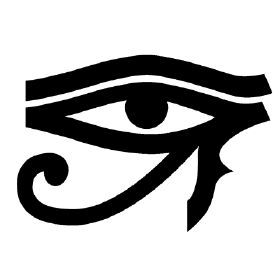

In [10]:
from IPython.display import Image

display(Image(filename="../img/developer_guides/sphinx_logo.png", embed=True))

## Building and Viewing the Documentation

In [ ]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAMAAAAt85rTAAAAh1BMVEX///8AAADBwcGHh4f7+/vw8PD5+fnq6urn5+f09PQzMzPt7e3x8fHKysp8fHxjY2PR0dHe3t6tra21tbXZ2dk7Ozuenp64uLhJSUlPT08aGhqQkJCXl5enp6fExMRCQkJcXFwVFRVUVFR1dXVtbW0mJiZgYGAkJCQtLS0ZGRk+Pj6KiooMDAz8fVLzAAAMYUlEQVR4nO2dZ5+qOBuHz1ADSpUiAlItM/r9P9+D046QQKq6u0+uV/s7O4T8IeVuwT9/JBKJRCKRSCQSiUQikUgkEolEIpFIJBKJRCKRSCQSiUTyf4cefLF6dUfEYukgUFz7bcxW9U3T0l7dOS60VeArStJt39A0575QHD/QX91RJoy0cL1s+t5g3u2sdxPn1d2lwhreWr3dYbXdcW49NfwXTE1jbUb5iUbZmFYB+j93XhpOqdYc6r7YuoUCXi0FRVS63OJ+qBP/1XLGWPu8ta+i5N04t10YvFrWJ8bKVEQqG1EC03qtvGCvfjxM3o2TVzqv2iYtv1TntnCR7PpiEz1fnnOszkJn3RLvdrV5ojZrFSR4C0U4fbR6xoQEadFXz1f3id2VykOtgGiT5O2LxP3gJumSGWCwqwuGre79xeo+2cV9gh6rezVTGZQZqyhUuUalndWeqyabNAC3zdsc3MM0V/s6YzcOTl0RKlEEAAj8KN0kqve9KtCq0yJF5VpQ7FZNZhf5wbzLqJwOPHtybVaklIXLsY/vqi5J/WXDWQscpfBicQK3Jpk6xW0rm8d43irAJFzWtfXK9AtRChPM3Zy+rvg2cLvNNyzOgKlcvIrfIckwNrrKJ65WS8QNDN0MIt9x9so3jjMsECa8p1mDyLjhU4iZhRwCD+keNeOc5OL2x6yyd3973jRx1XqumzjQKF5FzqbnEdgtTwxmgTVqA/YTLzssXXXY9gjn1vI71m4MLI9RFoFVrabjVjTTD1WvIW3A7vN0GjwMkm5L3MCI5c2eVuC16vPxmAD+Ps0ZutaWeycaqdRC12PYhBuBAr1k0qdb3OlM36dvTlVfKCNzcuWnakPbzKJrRS7wvQ3B6N0FZbc84Yg4bYendi/SMP2O7pllS8sMmcDTdjLp1lHNomaW7XQTyT/Ibbpm6RXiBZ62XTHaa9aRU4r3ouxcie5D3VZ6aUnHR84ucFfsnWA8MPO+anjVoIk9t7y/FXD2JdFgZXyDg0Ptg9HA0RS1FmgoI7hmfTHa10znsrywNn0Iltx+pMBT3LoTC8jSgfOMmNon7jgcsyrreAcZzNfG3nrhgrQZga1alMrEODD80M2ap2j7xnaT/f3SCtIyKQYT8COOY/vYuXmRhJuIJGAxFlhdEImQqKRctsXQdOl0+TfW0YBvGhShqB+BzWAkRuZq+kyCjSs4C0HBbuuifBU6injbInM71sp0KPe6g121BW4Ron5aIeCKj1qoi61ISTq6uFPVFeU+Wv+JcH/YJhfaxeqjD53pzBnM+324WdMLNoL9pujoIjODRZlG3w8K69rV5p9AyVvK2NO1VfMkTffOgLLZlIV7vK0L1Kl+p6vsQ0N169oxV3dZaPwFN6NP082I3gXc7Q43Tu+/PVQJA7+GpZumk9O6Krv4GE6DWvirfs0O4G658zn4NQgMbzxRe2Kz75c6RwXVLfyF+d/Xrfkl9YQcg49sFw1Lu606kzFY46+9jIdVUPKE0Zed3RsMIYvYAfrs2MdfDlnGxipy6Xsx1xqfwMFGDZczzPg2FOR1IWNFygGXDKYR2Ob4Oe3hGolne7Q/sii8CBJoH8nqdRxcQ938yr7aFxm1wBrTKzKBCVityQxcHbdiFEtXazq4UAq8YjZ7nEDbKxyqorlwub0T1vgwFJUqQNrzRbb71A8QSYV5ouVX2JO0sQ5pdo7l5AR+iDYftVuSv0RtuUWyursNjTG8/MwIF5mYYAH9BixZfDVJC4bbUOjDpLEptoljGBDZtpv5JmL8Y7Ic7E4z4tz2i0leqo3+qiqYFPVym2dsiRZQqJyMwVHD5V5pTbVDrW5wa441s9RXuLIeh64sJ7952DgYbNEGmeO7R1NQUarFFMLw8kIql8bbL4ZDeQR+4UaLKyvk2Z/QNug3a4fKhonTpcZGlDZz4Yqd7H0w91a0pL5v+NQv7FaBE9IMzaYvKYq8rchRQuZwvF13+VzPgZO6X7VgVbF3ZieLRVsclM+3NYvply6zyEPWqyV6Thrg6+jS7GTxC4/S23V99vpDp9uyj9c3+6IAk/QQhGasVwH9wLEXLXUSojRR6T2WX3ZZnyehEiyPIVPZFC5D4vuUiKnLD5S+Ydd4YxizRTIY6dBSACKlzFUmv3Z4feQrJw7LdFTO+q7hbZ7jjyw7er+0WRZzlMMlwk86WQVfeZ5Irh+i1X0RKQn76iqQQ8KQhCBEizZPOS2xRP3Y0vRb7WDYvFBfz1F5Tk5Yx4KLkYn1Pes4E0iLrnm+PveZR5msfUmZF+XX9+zjaNYKJE/M2R9fc/7VUNRjJXpKnhv435ZqtB6NnvKdHoFQ4R23JTwz8CgGO0Bc3dqxgMymnTjrkxlrZYJQRJlQZiTQvxFFwZ8DcBK35vEmsz9/cugfH3M029B1nW1p1gZv8tIdKxsunBuB+L9bgAp/CVY2EISF2/V937kFq29pmZHv7PdKWuZtNhm7WdYP7jAiflYN70qD0tieUG23Stf742/2kXeAaLpu3o7DKZsb/vCfX0NDgX2wWyQCFshyNnAOUCIqlE7pA6xcVPLps+gTFugKu2kUzmSrVOEfmTBK6CaH7vP/wAJtUTdN533aregD7fCpul34ZY3BAt/EeLnAXVrcYyH3+EEr4BX0JxKIECjkLH2ACUm0Im7yAzw+/55vRAjcCrilhUsKnMXttlrZQM0ff7dchMB3fMk5FnxySZxBD5sqb/3fWCBC4JvNuwRoBCdpPwStM2vEs3TvVmmUQO5FTiFxXUt8OwSsEFnf0fliA12Qx+VQ6ERZOcwRUsJbwfbZdTz4dXQxdDPzFQQiyIoYjwK2owjR+24cjVjNFFdc2ReBgEjfW8WfFAgQGatp8cecwLfrkdXwR8yKBjEp+QWiKhD7aTQJLBzSwFUUooHrAvsiRFQpebxDNEV0uYBmFuotf3F2L0yx+2k4Pr7V8iLSEKSl+zMYJTwqdojvMwQzGZC6ZE1aT/al7jOCjFhX+SxCExGVuqIslAjt0QDm8TMZ8/aXSQbPdD5bzUC9F6Sj5yNCV7uCY/REYyv7u0wHXg9cnhHqoyYWupLAgUdyRvGxGESDIy/p11yBHiKPKZEi3l81Y0HD39vjtERHDZ5+N6XpI684kgM5YtM5zfUaLoXmtUPv2/qbg4vGBXE79hs4qNK6bO6vjaktfuV1d0cC75btcTkr+wBFFhx6s0YDZBcvHD8g7MCMjvWdhWqHzAO0RBU2L1gkoBn/KbcrOBZ4X+pogd+bsFcWIe34zYJjMF1j+PMS9y0exnudFXZt1rrMw9NApkjPi+1NXzjuW1R47gXGQtMcABkH2S7ew5j+OX+P7gXaIgWmSKvZW3YIIAODvx/3Aq9cJsOkXXT5F8akhIJD/B1xmrvmhH2u1EEmQ0/YGTXdJATkJZz7J83pEv0AEJHPt9tX87CdmRoF2CvwjA5RfQiptinRPmuP3W3giJqArM/YXRKwyuxnvhHg4kMekKuUiXjg48Wct2ADzMSMahJbCFpiuHy0H8ZVDXwlffrcuY6axOKCnVD+bX4gGhkPPMa7UfboEPm1IBoYUPQLf0yUiEnMgrVRbWZtGXwtorUQERR2xVSoTVzMhsV+N1abufwpfvP7JEIkKIWMUPizDFdq58hY+PR9TzgiED8NcBD1gynThN1VpfOPInU+++2ShvsQAitR1R0rKAoa58TbBdgsfMrqmhAPBoRAcQUyPuINeJGJe/iGbqKu/OVMk1KEBb7zSJr0FHkW9XRMlPnTj6afYr6x5lKtVrBAga4NYpB+8+FdilJx/AgAXfvEAsBXwkQ9Ys6hZhu6GQQJrIRWoQNUH384Hc52HFfbT6o4Pp+aZXEDgLZ7kEBBe8Rs+zzsMH47SQe2on/bBpUSZERlSeNNBQqojZngiKkt36ls1uxE4CPOuZgiFLom4+48EfiYcxIF3zBtWkoT6J5xEuhRv2rn85ygi7mmzb3Ak8gtcExQsh6EzOZ/P4OIe4HkBh4DOqoYAktp8m7LdwI7IUKW7uW2FId2z1kuIiD+V+DD9d3Yq0fUIakpt18/EbQe/Aqczx2KxfQdpVhcc7ap4hB9P5iIH4H9Mw9CanpQor9xeu2g31Hg5Ftg/JpfkdSjKA0/D3ZswjR6yC8gfgmsH9H0P4ObwOvTDiK/gJtA4gDOvxFl9M3Y/yDKbGnQf4TgP65PIpFIJBKJRCKRSCQSiUQikUgkEolEIpFIJBKJ5B/H/wCW0dXtHvda6gAAAABJRU5ErkJggg==